# Exploring Audio Data, Extracting Features
Kartik Nanda, Feb 2020

Citation: I used the following code from Aaqibb Saeed as a starting point: 
http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/

In [1]:
import glob
import os
from pathlib import Path
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')
# plt.style.use('classic')

## Define key Functions
Functions to load audio files, plot waveform and transforms, extract features for further processing

In [19]:
# Load the sound file - currently it also does the following:
# generates plots: time, log_power_spectrogram
# input: single audio file, 
#        label, 
#        sample-rate (when loading, resamples to this rate, default=keep original file rate),
#        n_fft (number of samples used per fft, preferably power of 2, default=2048),
#        hop_length (determines overlap: hop = 0 means 100% overlap, hop = n_fft mean no overlap; def = n_fft/2)
#        p: set to True to generate plots

def load_sound(sound_file, sound_label, sr=None, n_fft=2048, hop_length=None, p=True):
    
    # Load the audio file (specify sample_rate sr)
    print('Original Sample Rate: ', librosa.get_samplerate(sound_file))
    X, _sr = librosa.load(sound_file, sr)
    print('Sample Rate of loaded file (resampled):', _sr)
    print('Number of audio samples: ', X.shape[0])
    
    # Generate plots - time domain waveform, log power-spectrogram
    if (p):
        fig = plt.figure(figsize=(25,12))
        plt.subplot(2, 1, 1)
        librosa.display.waveplot(np.array(X), sr=_sr)              # plot the waveform
        plt.title("Waveplot")
    
        # Generate and Plot the spectrogram (DB scale)
        if hop_length == None:
            hop_length = int(n_fft/2)
        X_stft_cmplx = librosa.stft(X, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, center=True)
        X_stft_amp_db = librosa.amplitude_to_db(np.abs(X_stft_cmplx), ref=np.max)
        print(X_stft_amp_db.shape)

        plt.subplot(2, 1, 2)
        librosa.display.specshow(X_stft_amp_db, sr=_sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='magma');
        # plt.colorbar();
        plt.title("Log Power Spectrogram")
        plt.suptitle(sound_label.title(),x=0.5, y=0.95, fontsize=18)
        plt.show()

        print('Number of FFT slices', X_stft_amp_db.shape[1])

    return X, _sr


In [73]:
# Extract features from audio files, optionally plot features
# Features are chroma, mel, contrast, tonnetz
def extract_feature(X, sound_label, sr, n_fft=2048, hop_length=None, p=True, n_chroma=12, n_mels=128, n_bands=6):
    print ("Audio samples :",len(X), "sampled at ", sr, "hz")
    if hop_length == None:
        hop_length = int(n_fft/2)
    
    # Calc. the Spectrogram (magnitude/energy and power)
    stft = np.abs(librosa.stft(X, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, center=True))
    X_spectrogram = np.abs(stft)**2
    
    # Calc. the mel-spectrogram, chroma, contrast and tonnetz
    mel = librosa.feature.melspectrogram(y=None, sr=sr, S=X_spectrogram, n_fft=n_fft, hop_length=hop_length, 
                                         win_length=n_fft, center=True, n_mels=n_mels)
    contrast = librosa.feature.spectral_contrast(y=None, sr=sr, S=stft, n_fft=n_fft, hop_length=hop_length, 
                                                 win_length=n_fft, center=True, freq=None, fmin=int(sr/(2**(n_bands+1))), 
                                                 n_bands=n_bands, quantile=0.02, linear=False)
    
    # Calc the chroma and tonnetz only if sr >=22050
    sr_gt_22000 = sr > 22000
    if sr_gt_22000:
        #chroma = librosa.feature.chroma_stft(y=None, sr=sr, S=X_spectrogram, norm=np.inf, n_fft=n_fft, hop_length=hop_length, 
        #                                     win_length=n_fft, center=True, n_chroma=n_chroma)
        chroma = librosa.feature.chroma_cqt(y=X, sr=sr, norm=np.inf, hop_length=hop_length, n_chroma=n_chroma)
        tonnetz = librosa.feature.tonnetz(y=X, sr=sr, chroma=chroma)
        
    if sr_gt_22000:
        print('Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz): ', 
              chroma.shape, mel.shape, contrast.shape, tonnetz.shape)
    else: 
        print('Feature Shapes (mel-spectrogram, contrast (chroma and tonnetz not computed for sr < 22050)): ', 
              mel.shape, contrast.shape)
    
    # Calc the output features
    # Mean of ch, co and t, but max for mel-spectrogram. Mean might also work
    chroma_avg   = (np.mean(chroma, axis=1) if sr_gt_22000 else np.zeros(n_chroma))
    mel_max      = np.max(mel, axis=1)
    contrast_avg = np.mean(contrast, axis=1)
    tonnetz_avg  = np.mean(tonnetz, axis=1) if sr_gt_22000 else np.zeros(n_bands)
    
    if (p):
        num_p = 4 if sr_gt_22000 else 2
        
        fig = plt.figure(figsize=(25,6*num_p))
        plt.subplot(num_p, 1, 1)
        librosa.display.specshow(contrast, sr=sr, hop_length=hop_length)
        plt.colorbar();
        plt.ylabel('Frequency bands')
        plt.title('Contrast')
 
        plt.subplot(num_p, 1, 2)
        librosa.display.specshow(mel, sr=sr, hop_length=hop_length, y_axis='mel', fmax=sr/2)
        plt.colorbar();
        plt.title('Mel Spectrum')
        
        if sr_gt_22000:
            plt.subplot(num_p, 1, 3)
            librosa.display.specshow(chroma, sr=sr, hop_length=hop_length, y_axis='chroma')
            plt.colorbar();
            plt.title('Chroma')

            plt.subplot(num_p, 1, 4)
            librosa.display.specshow(tonnetz, sr=sr, hop_length=hop_length, y_axis='tonnetz', x_axis='time')
            plt.colorbar();
            plt.title('Tonnetz')
            plt.suptitle(sound_label.title(),x=0.5, y=0.95,fontsize=18)

        plt.show()
    return chroma_avg, mel_max, contrast_avg, tonnetz_avg

## Path Setup
Finding the Audio files

The original uses the UrbanSound8K dataset, which can be found here: (https://urbansounddataset.weebly.com/).
It is a collection of 8732 short clips covering 10 different sounds from urban environments.

For our purpose, we use the data in the datasets folder (Under water audio), and extract simple features from the audio files.

The folder structure:

    audio_anomaly_model/audio_baseline/ contains this script
    audio_anomaly_model/datasets/ contains the dataset
    audio_anomaly_model/features/ contains the features output


In [4]:
# Define paths
path_proj = Path.cwd().parent                        # The project directory
path_raw_audio = path_proj/'datasets'/'downloaded'   # The downloaded audio files
path_dataset = path_proj/'datasets'/'data_uw_sounds' # Dataset for Under-Water Audio 
path_features = path_proj/'features'                 # The output folder - where the features are saved

In [75]:
# This is a list of all the directories which contain the audio clips
file_paths = list(path_dataset.glob('*'))

In [76]:
len(file_paths)

800

## Testing the functions
Also serves as a place to play around with files.

In [10]:
file1 = path_raw_audio/'iceburg_noises'/'Iceburg_Tremor.wav'
Path.is_file(file1)
class_name = file1.parent.name
class_name

'iceburg_noises'

Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  18371424
(1025, 17941)


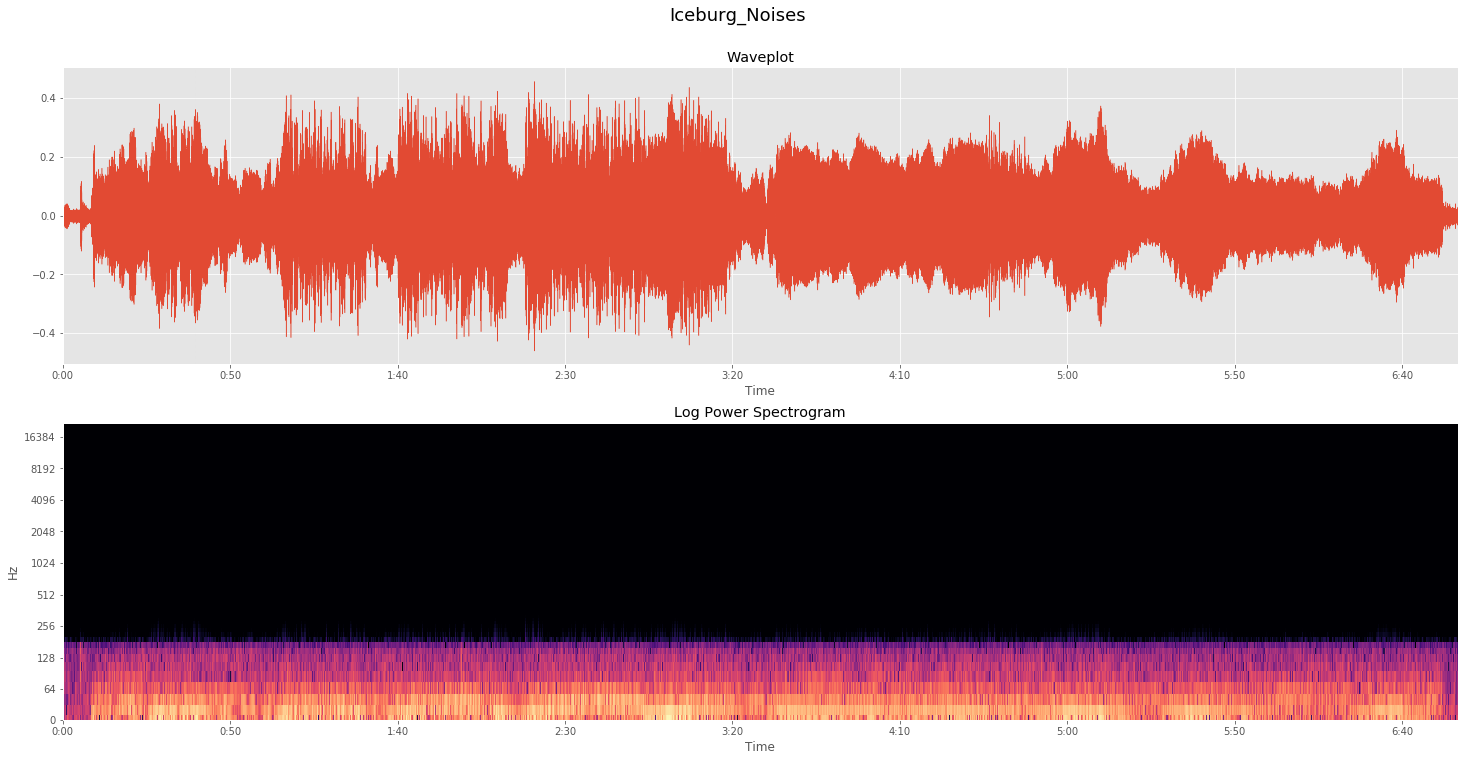

Number of FFT slices 17941


In [50]:
X, sr = load_sound(file1, class_name, sr=44100, p=True)

In [12]:
file2 = path_raw_audio/'iceburg_noises'/'Iceburg_Tremor_999.wav'

class_name = file2.parent.name
class_name

'iceburg_noises'

Original Sample Rate:  999
Sample Rate of loaded file (resampled): 1024
Number of audio samples:  426584
(1025, 417)


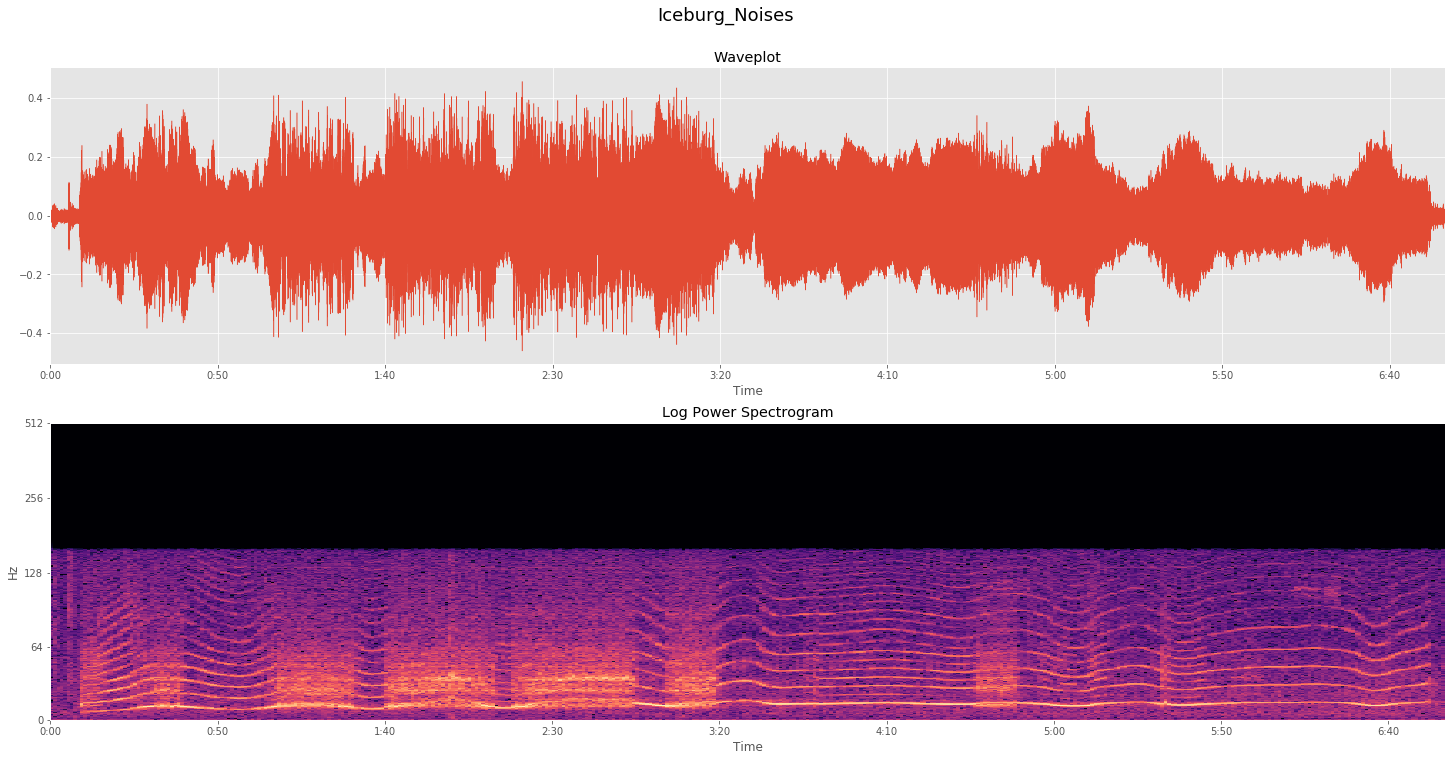

Number of FFT slices 417


In [21]:
X2, sr2 = load_sound(file2, class_name, sr=1024, p=True)

Audio samples : 18371424 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 17941) (128, 17941) (7, 17941) (6, 17941)


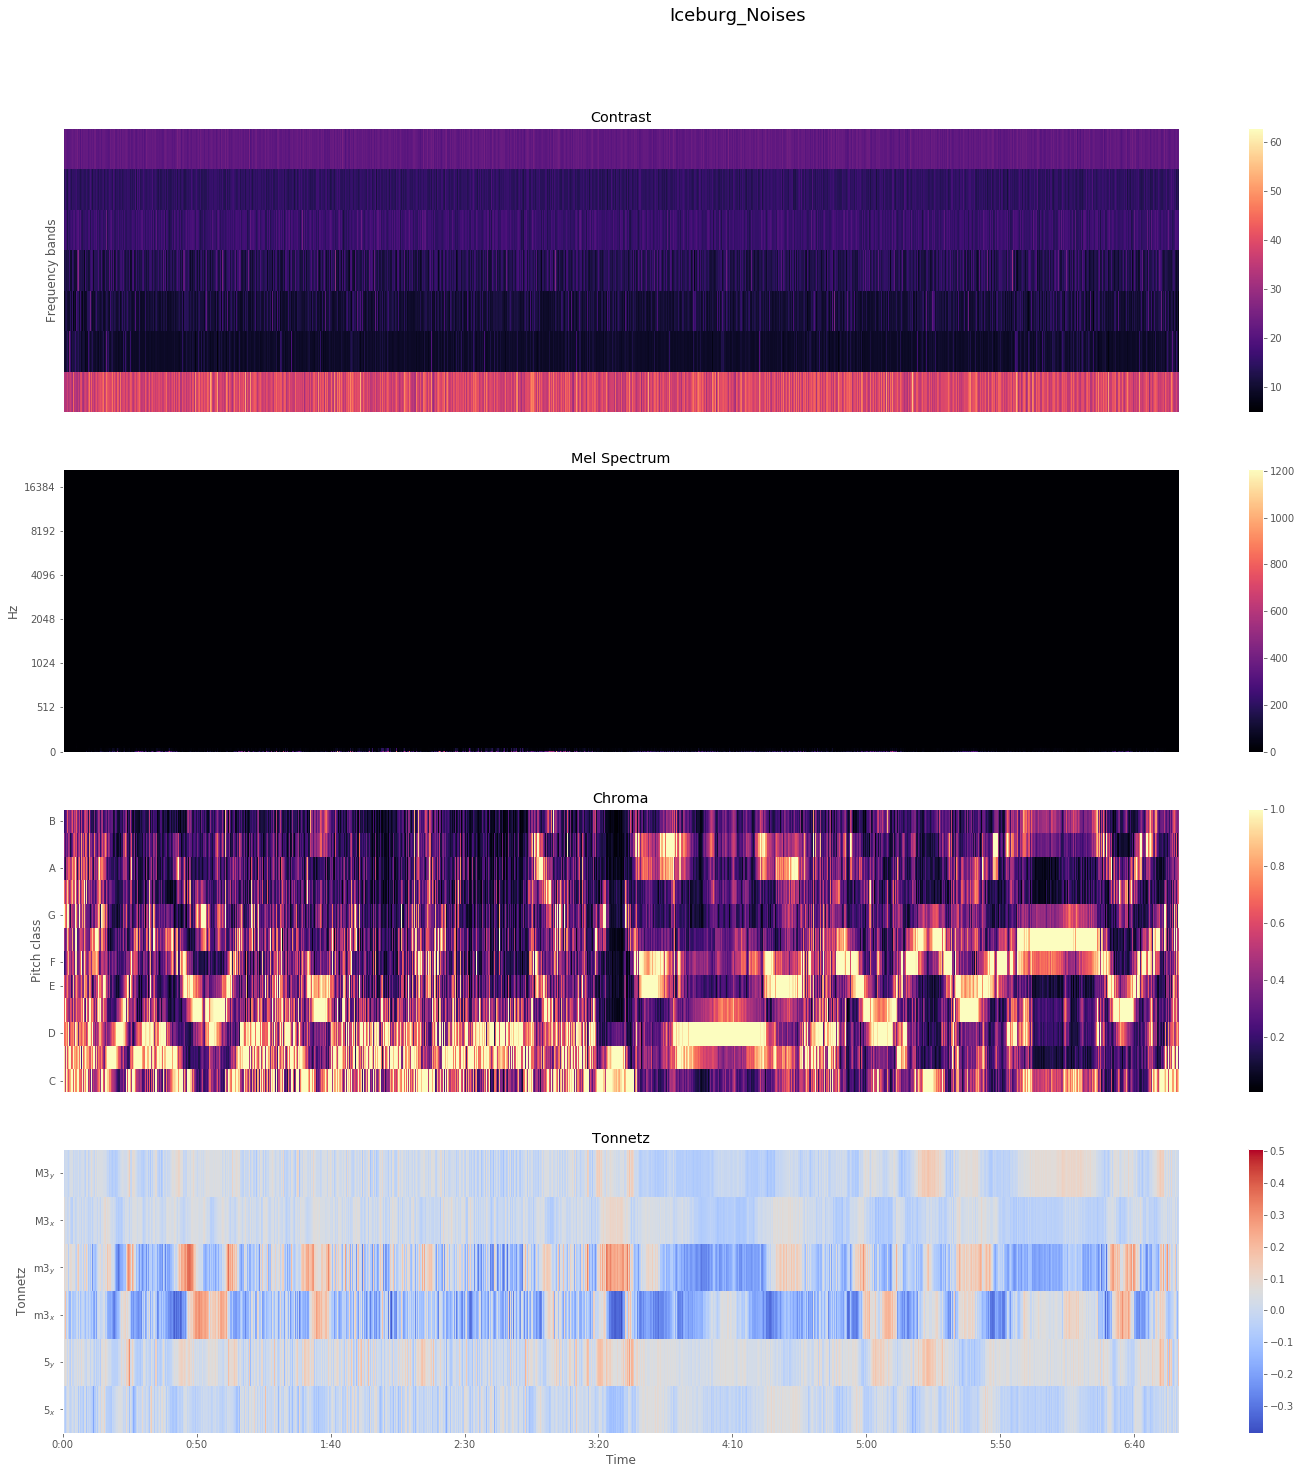

In [74]:
ch, m, co, t = extract_feature(X, class_name, sr=sr, p=True)

Audio samples : 426584 sampled at  1024 hz
Feature Shapes (mel-spectrogram, contrast (chroma and tonnetz not computed for sr < 22050)):  (128, 417) (7, 417)


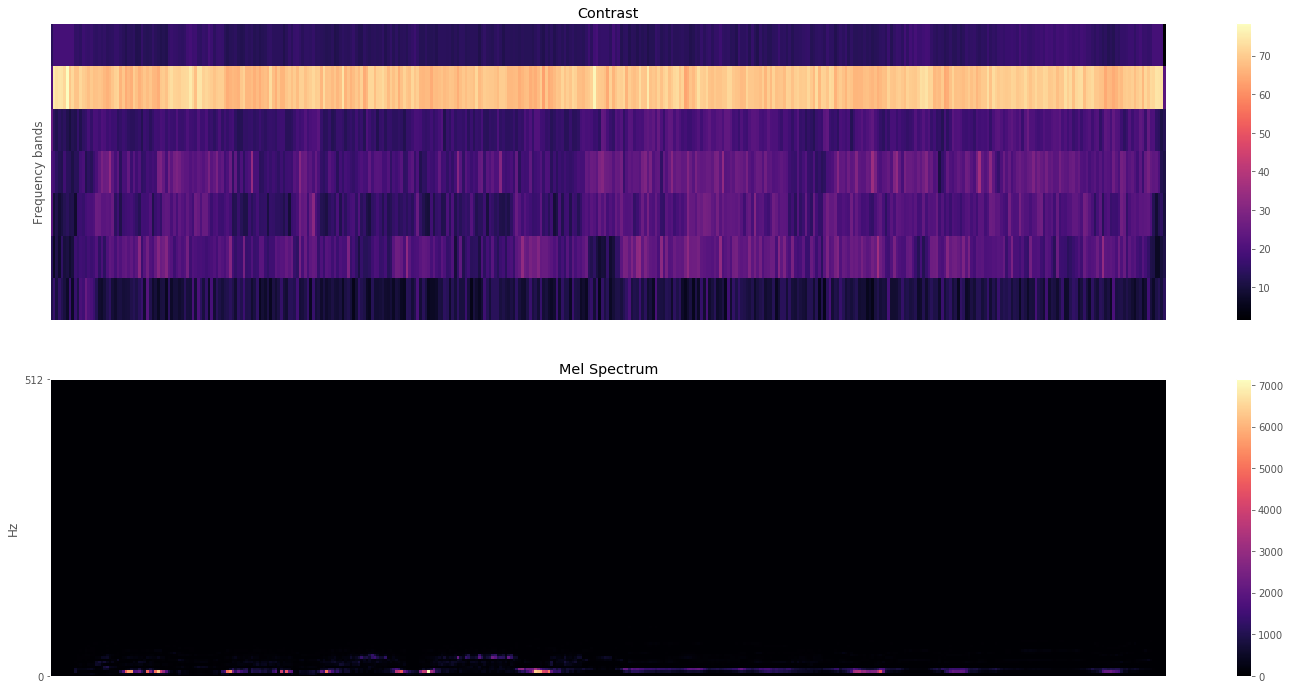

In [75]:
ch, m, co, t = extract_feature(X2, class_name, sr=sr2, p=True)

In [62]:
ch.shape, t.shape

((12,), (6,))

In [63]:
ch, t

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]))

## Main Loop
while there are files to extract:
    
    Load Audio file, 
    extract features,
    save features,
repeat


In [88]:
# Read in the audio clips, and save the features
# building a list of dictionaries
rows_list = []
for p in file_paths:
    class_name = p.name.split('-')[0]
    print('*************** File: ', p.name, ' *******************')
    X, sr = load_sound(p, class_name, sr=44100, p=False)
    ch, m, co, t = extract_feature(X, class_name, sr=sr, p=False)
    print('Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz): ', ch.shape, m.shape, co.shape, t.shape)
    td = dict([('class', class_name), ('chroma', ch), ('mel spectrogram', m), ('contrast', co), ('tonnetz', t)])
    rows_list.append(td)

*************** File:  blue_whale-0.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  blue_whale-1.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  blue_whale-10.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 17

C:\Users\kar16\AppData\Roaming\Python\Python36\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  blue_whale-11.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  blue_whale-2.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,)

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-2.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-20.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)


Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-39.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-4.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)


Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-58.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-59.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-77.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  dolphin-78.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-110.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-111.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-13.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-130.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,)

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-149.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-15.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,)

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-33.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-34.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-52.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-53.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-71.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-72.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-90.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  fin_whale-91.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-101.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-102.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-12.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-120.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-138.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-139.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-156.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-157.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-174.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-175.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-192.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-193.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-21.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-210.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-228.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-229.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-246.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-247.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-264.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-265.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-282.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-283.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-30.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-300.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-318.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-319.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-336.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-337.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-354.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-355.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-372.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-373.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-390.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-391.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-408.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-409.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-426.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-427.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-444.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-445.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-462.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-463.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-480.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-481.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-499.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-5.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (1

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-516.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-517.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-534.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-535.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) 

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-61.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-62.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (1

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-8.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-80.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (12

Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-98.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (128,) (7,) (6,)
*************** File:  humpback_whale-99.wav  *******************
Original Sample Rate:  44100
Sample Rate of loaded file (resampled): 44100
Number of audio samples:  176400
Audio samples : 176400 sampled at  44100 hz
Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12, 173) (128, 173) (7, 173) (6, 345)
Output Feature Shapes (chroma, mel-spectrogram, contrast, tonnetz):  (12,) (1

In [90]:
# Convert to a dataframe
df = pd.DataFrame(rows_list)
df.head(15)

,class,chroma,mel spectrogram,contrast,tonnetz
0,blue_whale,"[0.6940317, 0.6943238, 0.7100827, 0.73895323, ...","[68.262405, 370.14984, 247.70305, 14.562566, 0...","[13.267565070203402, 8.696950814232858, 10.539...","[-0.006859036657601042, 0.017247378957576883, ..."
1,blue_whale,"[0.6193697, 0.64046234, 0.6813503, 0.7825027, ...","[148.12704, 904.7659, 904.00287, 67.21762, 1.5...","[17.802202885303156, 11.370600439073105, 10.47...","[-0.012909111556220999, 0.004279597888204874, ..."
2,blue_whale,"[0.6719103, 0.7796876, 0.8642713, 0.9315912, 0...","[6559.597, 2774.6829, 51.6298, 5.559755, 1.695...","[26.836810551727204, 10.435809819698688, 10.25...","[0.059621203559155886, 0.02184179077263547, -0..."
3,blue_whale,"[0.7674555, 0.8603113, 0.9177927, 0.9478554, 0...","[6446.2485, 2735.556, 84.48368, 6.914464, 2.56...","[27.724387123522177, 9.986239225028534, 9.9894...","[0.07492855380338322, 0.04608425404206363, -0...."
4,blue_whale,"[0.64155793, 0.6515365, 0.6707401, 0.73512685,...","[49.174957, 889.72345, 832.1287, 54.36609, 1.6...","[16.583486008258575, 9.816188146128088, 10.599...","[0.008239554984272887, 0.022875858035287615, -..."
5,blue_whale,"[0.67144215, 0.6843769, 0.7108235, 0.77602834,...","[62.195683, 531.8513, 499.94876, 29.349771, 1....","[16.260962979170973, 10.083232248773825, 10.05...","[-0.006168494226929928, 0.018984940837385715, ..."
6,blue_whale,"[0.64537245, 0.67309254, 0.7065463, 0.74732053...","[136.74434, 491.2148, 368.93576, 23.397331, 0....","[14.137661553363358, 8.764974607197532, 10.228...","[-0.009278473218251777, 0.022942272008896824, ..."
7,blue_whale,"[0.6513076, 0.6319003, 0.6447659, 0.6672688, 0...","[0.0044238153, 0.0037665572, 0.002142864, 0.00...","[9.831316578788156, 7.62234105988228, 10.42351...","[0.00415125480839705, 0.014396945956344488, -0..."
8,blue_whale,"[0.7318929, 0.83965784, 0.8560867, 0.8067438, ...","[1714.5812, 912.6514, 39.219265, 2.7452319, 0....","[20.03834021580128, 9.808475584157899, 10.0718...","[0.003248430680836591, 0.048397005306590156, 0..."
9,blue_whale,"[0.8500015, 0.93112147, 0.9650094, 0.96903735,...","[1719.8031, 1268.8337, 48.75707, 3.8859367, 1....","[27.379122448043578, 9.943602817966202, 10.265...","[-0.047979172108029045, 0.044655637290253056, ..."


In [91]:
df.shape

(800, 5)

In [92]:
# Save the df as a csv file
name = path_features/'outfile.csv'
df.to_csv(name)